## order of operations and performance with numpy and Dask

The past couple days I've been attending the 2021 Dask Summit and have seen a bunch of interesting and useful talks. One session, the "Hacking Dask" tutorial, took a deep dive into various features of the Dask API, some of which I haven't yet spent much time working with. The section on how Dask optimizes a task graph before execution got me thinking about how to optimize some of my own problems in different ways and then in his talk today, Krishan Bhasin dropped this very helpful reminder: "Dask does exactly what you ask it to." This note of caution is a reminder to think through your problem before you even start using dask to see if there are ways to optimize. 

So given all this, I realized that in one my projects, I end up multiply arrays by constants fairly frequently. And in the case where the ultimate result is a reduced array, then I might be doing some extra work. 

Consider the following deceptively simple calculation where we multiple an array of some length by a constant and then take the mean:

```
mean(array * constant)
```


If our `array` has a length `N`, this will first exceute an element-wise multiplication of `constant` onto each element in `array`, so that is `N` multiplications before finding the mean of the result. But if we think about the reduction operation here (taking the `mean`), we can write this instead as 

```
constant * mean(array) 
```

These two calculations are mathetmically identical, but in the second case we cut out `N-1` multiplications! `mean(array)` returns a single value, so that the multiplication of the constant adds only a single operation. 

So how big of a difference does this make? 

## numpy baseline

So what we'll do is run through a range of array sizes and compare the time it takes to take the mean first, `constant * mean(array)` to the time it takes to take the mean second, `mean(array*constants)`. 

Let's check it out first with vanilla numpy.

In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt

we'll test a large range of array sizes from 10^5 to 10^9:

In [2]:
logsize = np.arange(5,10)
szs = 10**logsize

so here we just loop over the test sizes, built a random array and execute the two operations:

In [3]:
results_np = {'mean_first':np.array([]),
              'mean_second':np.array([])}

for sz_mag in logsize:
    a = np.random.random((10**sz_mag, ))
    
    start_time = timeit.default_timer()
    result = a.mean() * 5
    # code you want to evaluate
    elapsed = timeit.default_timer() - start_time
    results_np['mean_first']=np.append(results_np['mean_first'], elapsed)
    
    
    start_time = timeit.default_timer()
    result = (a* 5).mean()     
    elapsed = timeit.default_timer() - start_time
    results_np['mean_second']=np.append(results_np['mean_second'], elapsed)
        
    del a
    
    

and a couple of helpful functions to plot results that will get re-used:

In [4]:
def plot_results(results, xlabl = "array size", title=None):
    f = plt.figure(figsize=(12,5))
    
    ax1 = plt.subplot(1,2,1)
    plt.plot(szs, results['mean_first'], label='mean first', marker='.')
    plt.plot(szs, results['mean_second'],label='mean second', marker='.')
    plt.legend()
    ax1.tick_params(axis='both', labelsize=12)
    plt.xlabel(xlabl, fontsize=14)
    plt.ylabel("time (s)", fontsize=14)
    ax2 = plt.subplot(1,2,2)
    plt.loglog(szs, results['mean_first'], label='mean first', marker='.')
    plt.loglog(szs, results['mean_second'],label='mean second', marker='.')
    plt.xlabel(xlabl)
    ax2.tick_params(axis='both', labelsize=12)
    
    if title:
        f.suptitle(title, fontsize=14)
    return f

def plot_ratio(results,title=None):
    f = plt.figure()
    plt.semilogx(szs, 
             results['mean_second']/results['mean_first'],
             color='k',
             marker='.')
    plt.xlabel('chunk size', fontsize=14)
    plt.ylabel('mean second / mean first', fontsize=14)
    plt.gca().tick_params(axis='both', labelsize=12)
    if title:
        f.suptitle(title,fontsize=14)

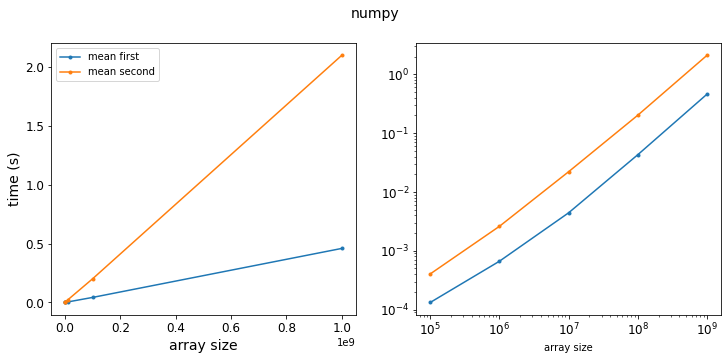

In [5]:
f = plot_results(results_np, title="numpy")

Ok, so we see our expected result: taking the mean first and then multiply is faster since there are few operations. The ratio of the two curves shows that taking the mean first is about 4 times faster.

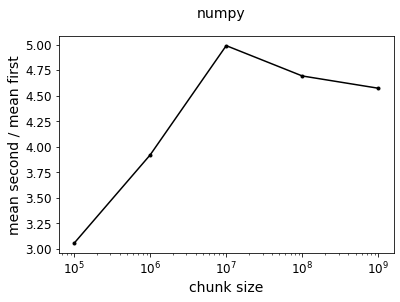

In [6]:
f = plot_ratio(results_np, title="numpy")

## Dask

Now, things get a little more interesting with Dask. 

Let's say we have a random array with 10 chunks:

In [7]:
import dask.array as da
a = da.random.random((100_000, ), chunks=10_000)
a

dask.array<random_sample, shape=(100000,), dtype=float64, chunksize=(10000,), chunktype=numpy.ndarray>

we can actually visualize the difference in the two operations by looking at the dask task graph. 

Here's the case where we take the mean after multiplying:

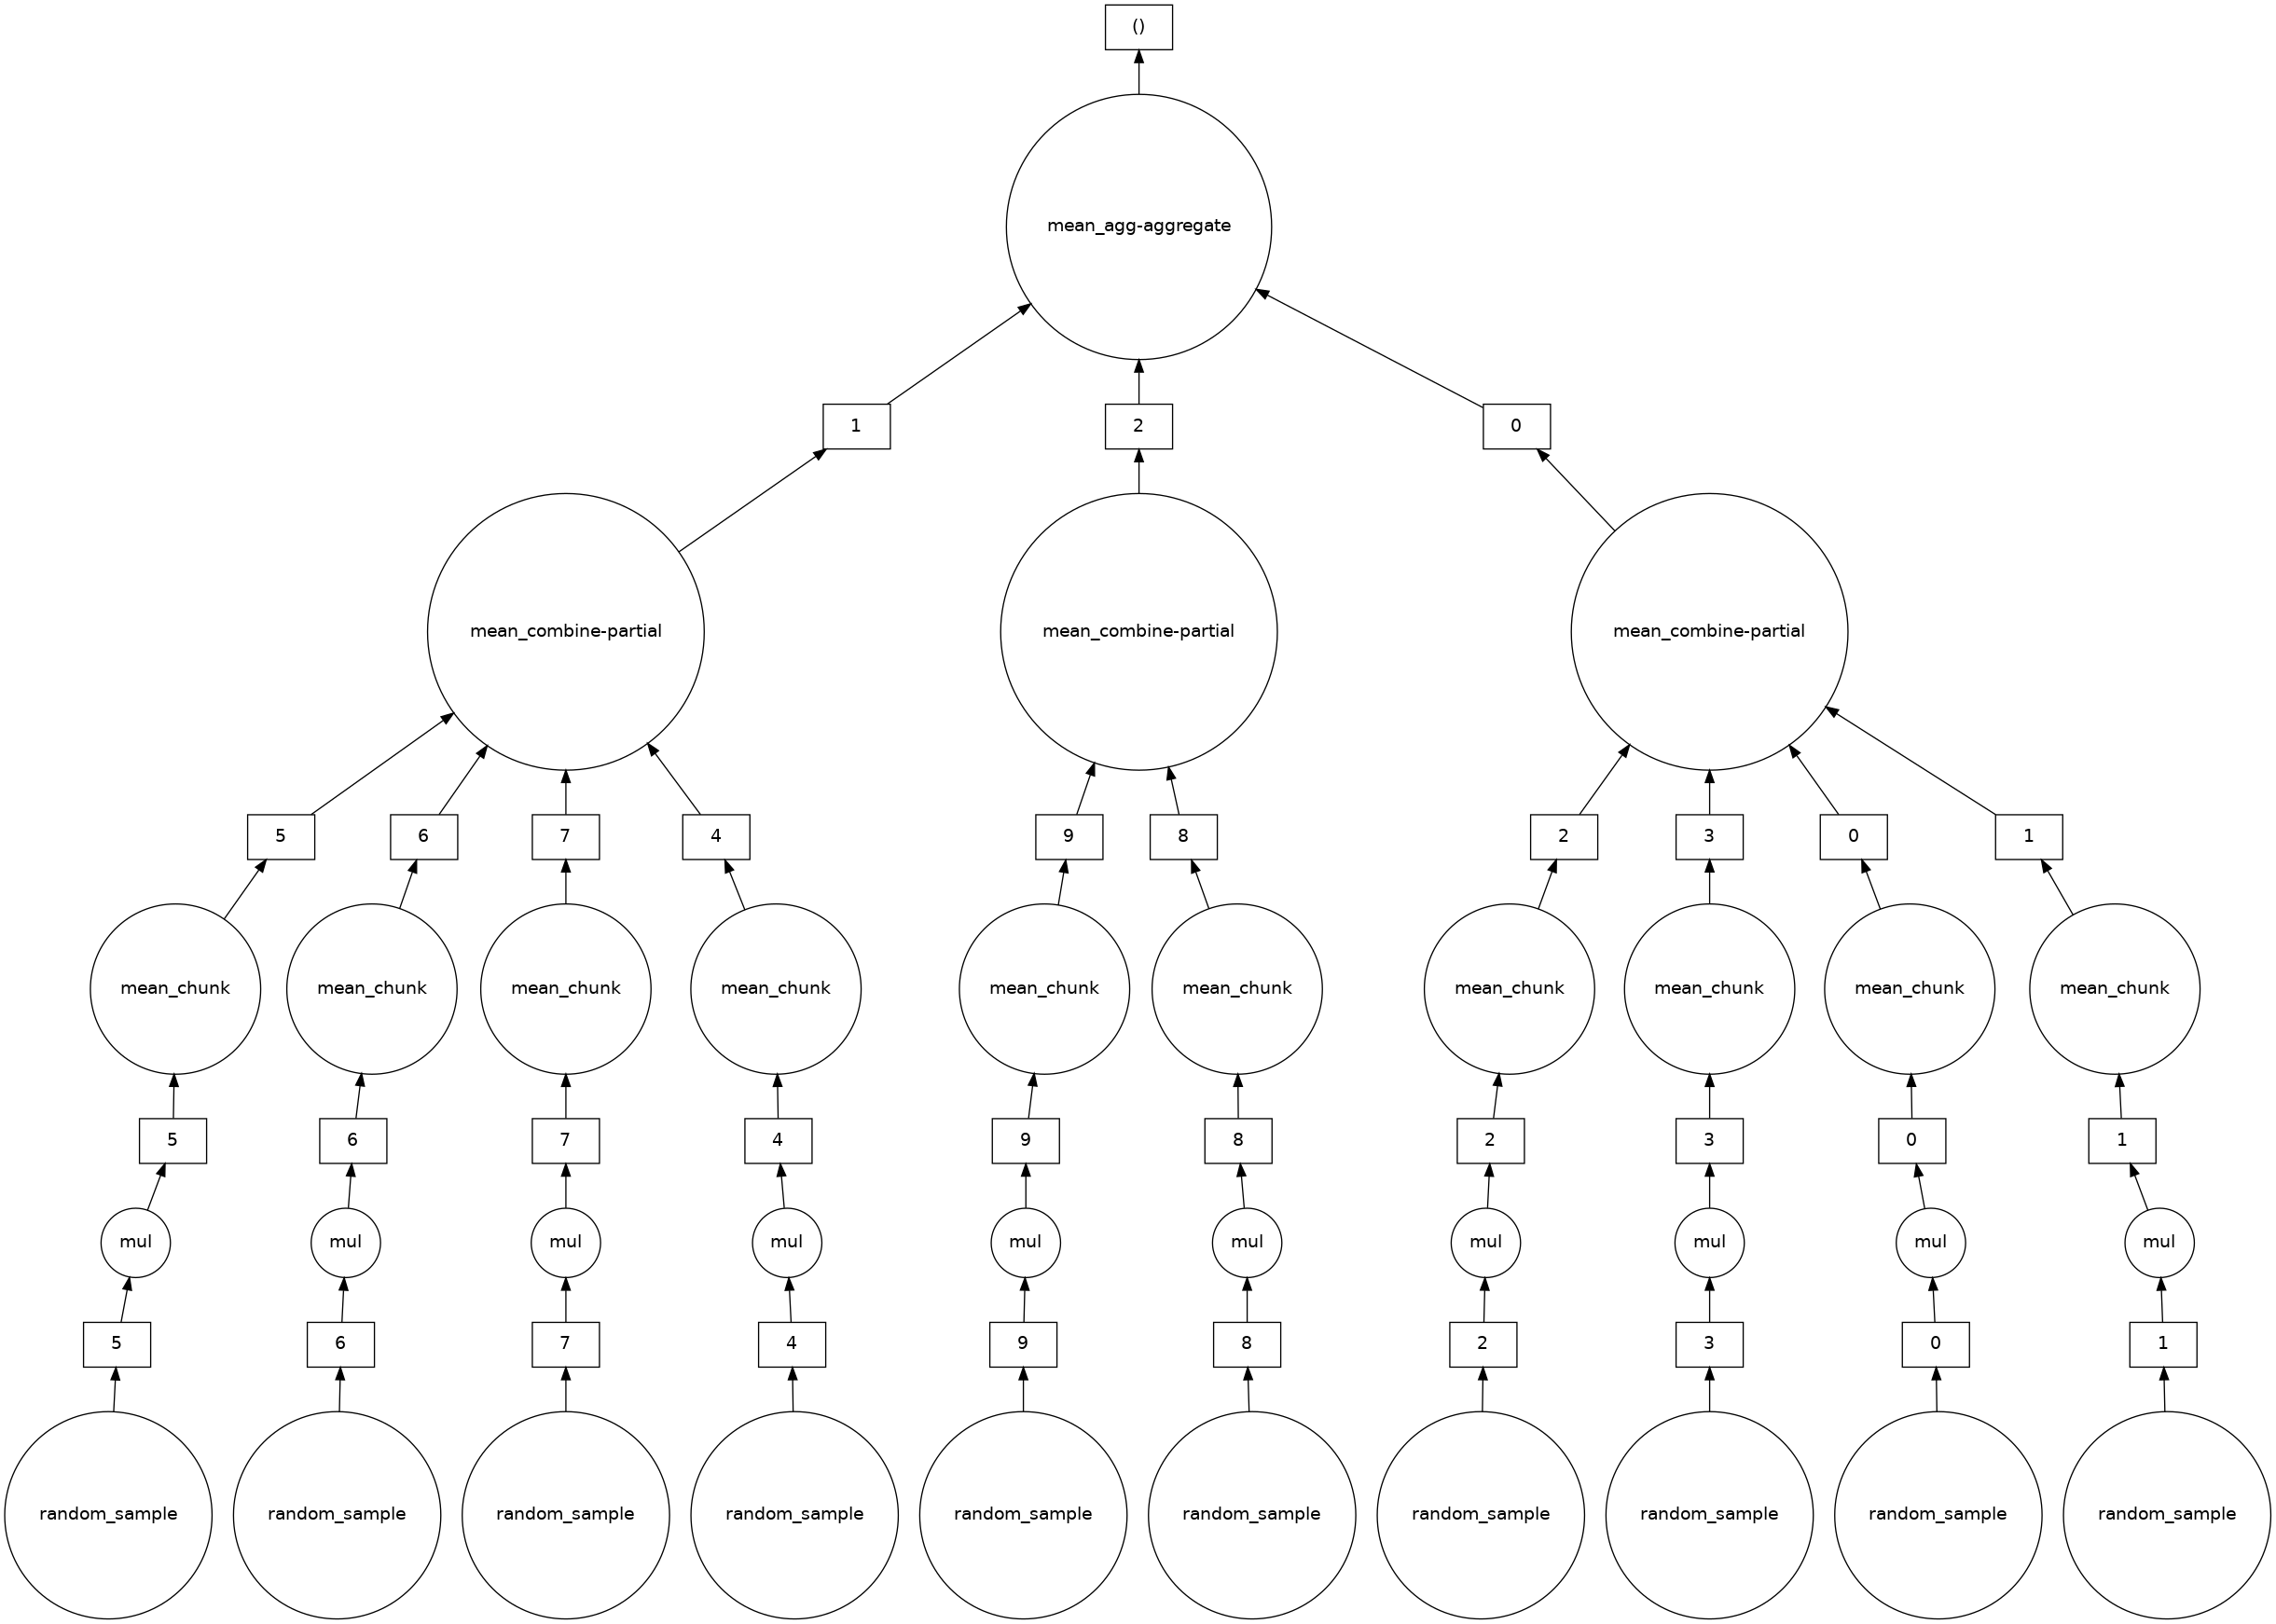

In [8]:
mean_second = (5 * a).mean()
mean_second.visualize()

So we see that for each `random_sample` chunk, we have a `mul` step, where we do an element-wise multiplication on each chunk. The `mean` call then reduces and aggregates by-chunk to eventually get the mean.

Ok, so let's take the mean first:

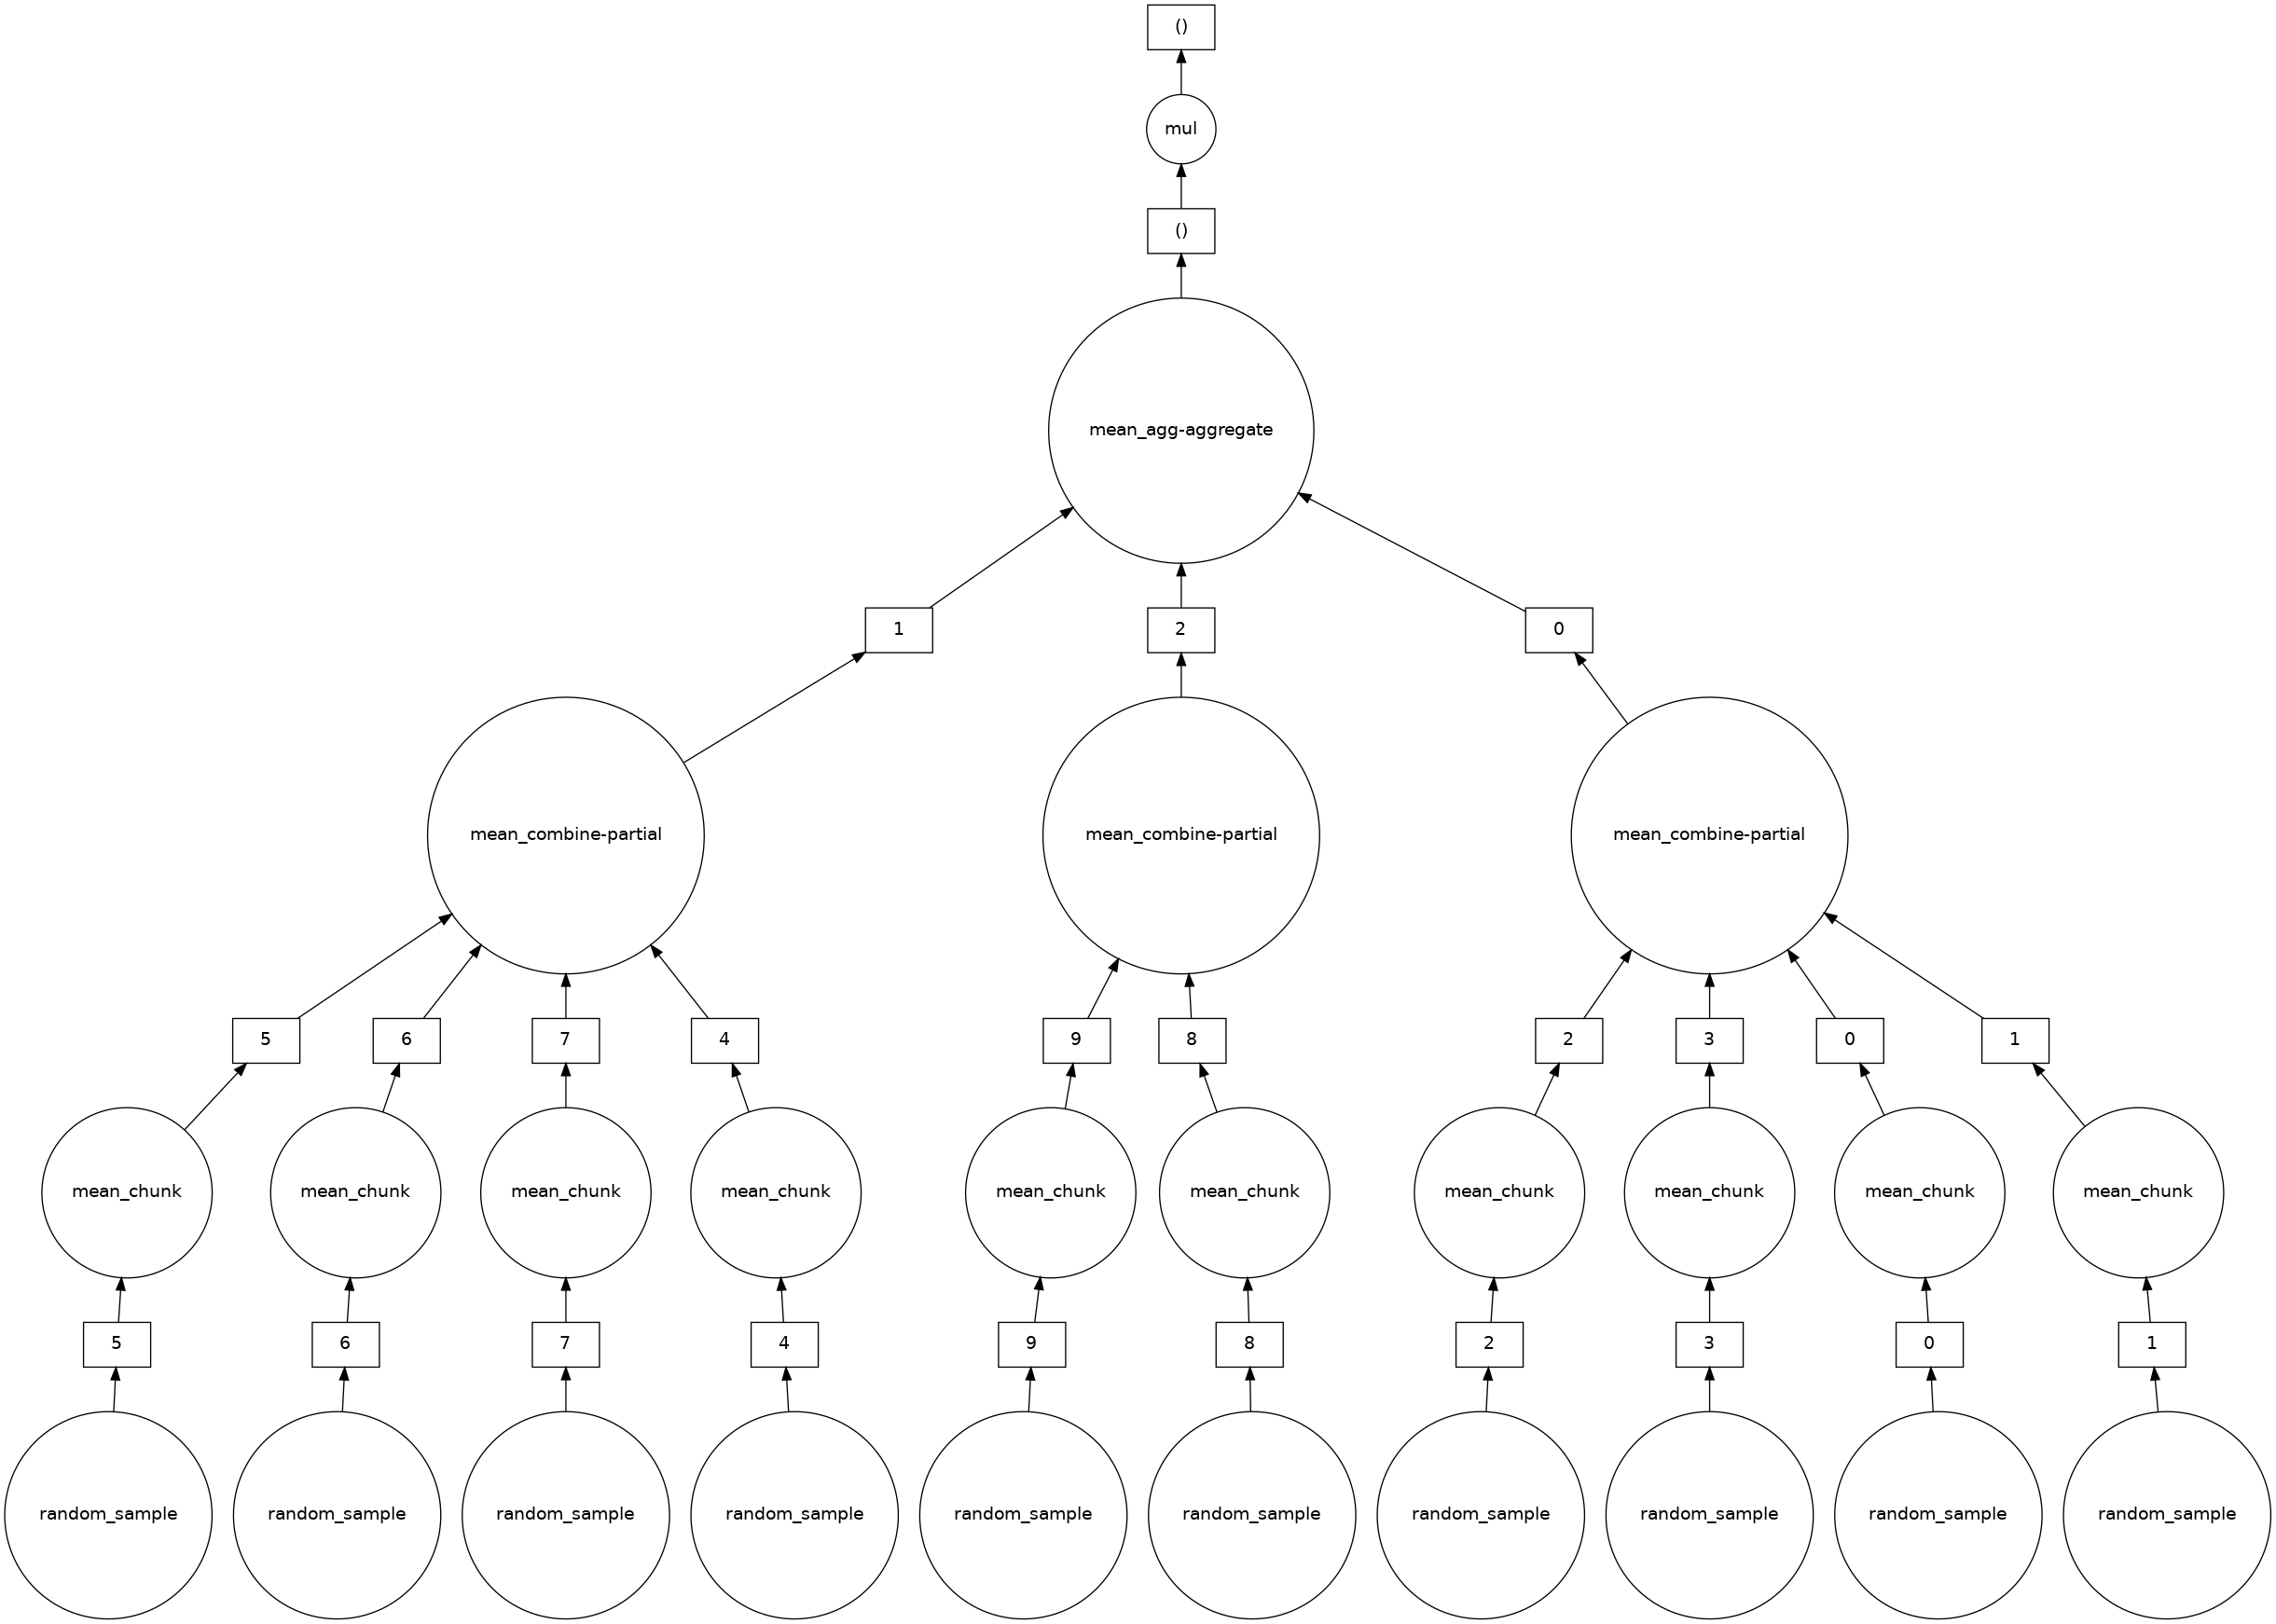

In [9]:
mean_first = a.mean() * 5
mean_first.visualize()

and we can see that the `mul` operation has been removed from the individual chunk step out to the top, final task.

Ok, so let's actually compute our different graphs and check out the difference in speed. 

We'll actually drop our test in a function so that we can run multiple tests varying the chunksize:

In [10]:
def run_dask_test(logsize, chunksize=10_000):
    results_dask = {'mean_first':np.array([]),
                  'mean_second':np.array([])}

    for sz_mag in logsize:
        a = da.random.random((10**sz_mag, ),chunks=chunksize)

        result = a.mean() * 5    
        start_time = timeit.default_timer()
        result_computed = result.compute()
        elapsed = timeit.default_timer() - start_time
        results_dask['mean_first']=np.append(results_dask['mean_first'], elapsed)

        result = (a* 5).mean() 
        start_time = timeit.default_timer()
        result_computed = result.compute()
        elapsed = timeit.default_timer() - start_time
        results_dask['mean_second']=np.append(results_dask['mean_second'], elapsed)

    return results_dask

In [11]:
results_dask = run_dask_test(logsize)

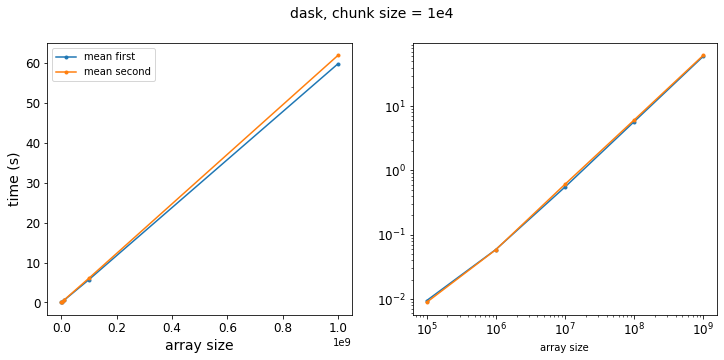

In [12]:
f = plot_results(results_dask, title="dask, chunk size = 1e4")

At first glance, it appears that dask is magic! Our two approaches now have virtually the same execution time! But wait... let's think for a minute here. The difference in number of operations is coming from our element-wise multiplication. In this case, though, the element-wise multiplication is applied to each **chunk** of the array, which then runs through the `mean` aggregation and reduction. So then the number of operations before we start the reduction step actually depends on the size of our chunks, not the total size of the array! 

So let's increase our chunk size a few times and see what happens:

In [13]:
results_dask_big_chunks = run_dask_test(logsize, chunksize=100_000)

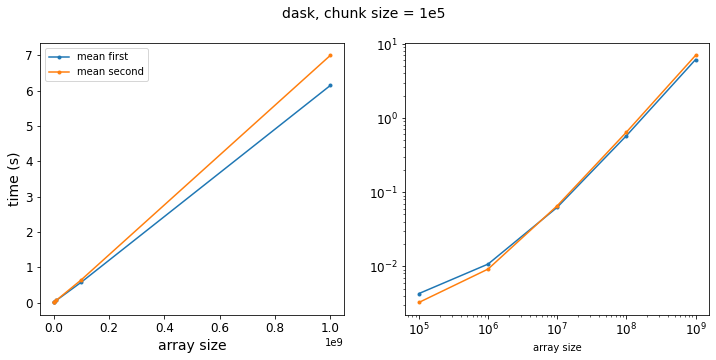

In [14]:
f = plot_results(results_dask_big_chunks, title="dask, chunk size = 1e5")

In [15]:
results_dask_bigger_chunks = run_dask_test(logsize, chunksize=1_000_000)

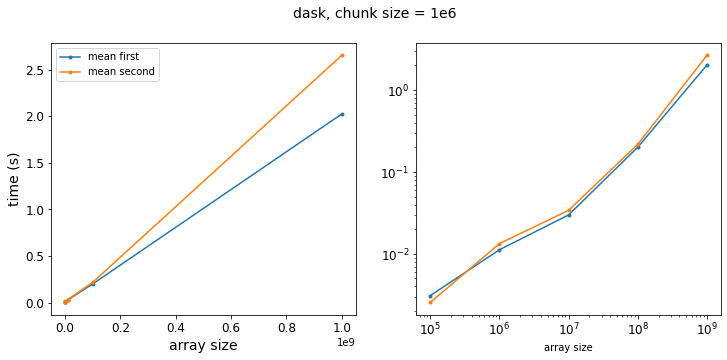

In [16]:
f = plot_results(results_dask_bigger_chunks, title="dask, chunk size = 1e6")

In [17]:
results_dask_even_bigger_chunks = run_dask_test(logsize, chunksize=10_000_000)

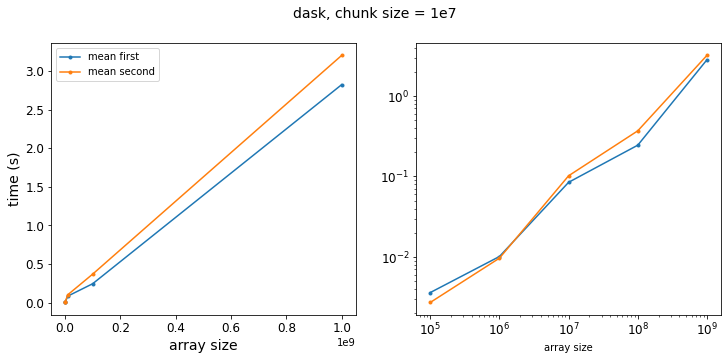

In [18]:
f = plot_results(results_dask_even_bigger_chunks, title="dask, chunk size = 1e7")

So as we get to larger chunk sizes, we start to see a difference in our two methods. Let's re-write our test function to vary the chunk size:

In [19]:
def run_dask_test_vary_chunks(logsize, array_size=10_000_000):
    results_dask = {'mean_first':np.array([]),
                  'mean_second':np.array([])}

    for sz_mag in logsize:
        chunksize=10**sz_mag
        a = da.random.random((array_size, ),chunks=chunksize)

        result = a.mean() * 5    
        start_time = timeit.default_timer()
        result_computed = result.compute()
        elapsed = timeit.default_timer() - start_time
        results_dask['mean_first']=np.append(results_dask['mean_first'], elapsed)

        result = (a* 5).mean() 
        start_time = timeit.default_timer()
        result_computed = result.compute()
        elapsed = timeit.default_timer() - start_time
        results_dask['mean_second']=np.append(results_dask['mean_second'], elapsed)

    return results_dask

In [20]:
results_dask_vary_chunks = run_dask_test_vary_chunks(logsize, array_size=100_000_000)

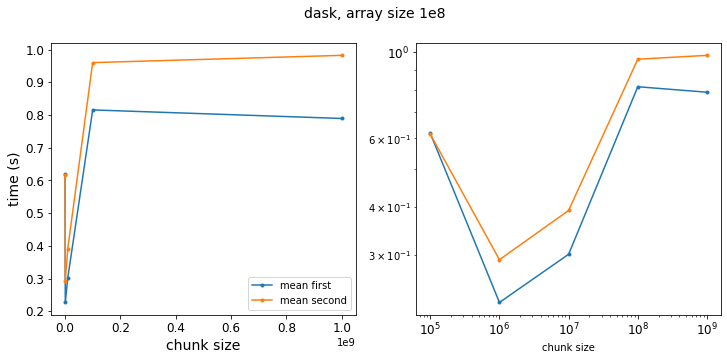

In [21]:
f = plot_results(results_dask_vary_chunks,xlabl='chunk size',title='dask, array size 1e8')

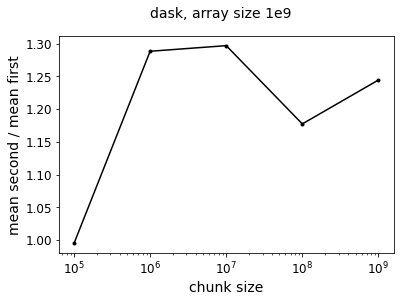

In [22]:
f = plot_ratio(results_dask_vary_chunks,title='dask, array size 1e9')

In [23]:
results_dask_vary_chunks = run_dask_test_vary_chunks(logsize, array_size=1_000_000_000)

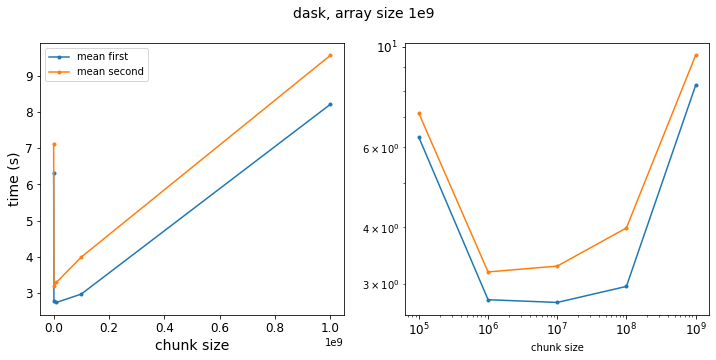

In [24]:
f = plot_results(results_dask_vary_chunks,xlabl='chunk size',title='dask, array size 1e9')

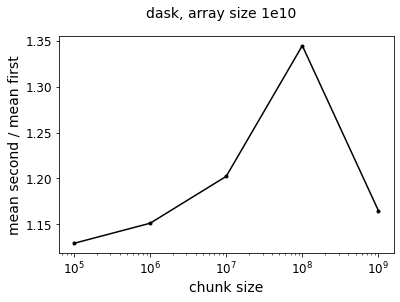

In [25]:
f = plot_ratio(results_dask_vary_chunks,title='dask, array size 1e10')

Now we see that taking the mean first is generally faster -- it **is** perhaps a little surprising that the speedup is not as pronounced as the pure numpy operation. Even at the limit where have a chunksize of 1e9, so that our dask arrays are single chunks, the two approaches only differ by a factor of 1.3. But this is because doing the calculation in Dask adds an overhead performance hit so that the absolute value of the speedup from taking the mean first is smaller relative to the total execution time.

In terms of absolute difference, we see an order of 1 second:

Text(0.5, 0.98, 'dask, array size 1e10')

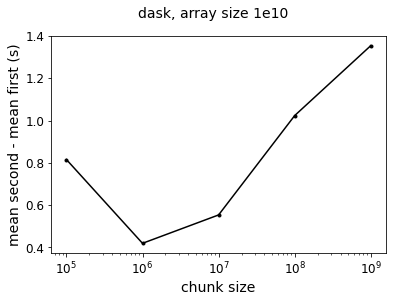

In [28]:
f = plt.figure()
plt.semilogx(szs, 
         results_dask_vary_chunks['mean_second'] - results_dask_vary_chunks['mean_first'],
         color='k',
         marker='.')
plt.xlabel('chunk size', fontsize=14)
plt.ylabel('mean second - mean first (s)', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=12)
f.suptitle("dask, array size 1e10",fontsize=14)

So overall, a difference of about 1 second is maybe not that big of a deal, but if your task graph has a bunch of operations that could be moved to after-reduction steps, re-arranging the order of operations could save you some computation time!